In [152]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import data
from skimage.filters import threshold_otsu, threshold_adaptive
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, Activation, MaxPooling2D
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt

In [2]:
# Features
from sklearn.base import TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_classif, RFE, SelectFdr, SelectFpr, SelectFromModel, SelectKBest, SelectPercentile
from sklearn.preprocessing import RobustScaler, StandardScaler, Imputer, MaxAbsScaler, MinMaxScaler

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile, VarianceThreshold

# Models - Linear
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# Models - Non-Linear
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

# Testing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

### Load Images, Labels

In [138]:
train_image_files = [x for x in os.listdir('../app/train_images/') if '.jpg' in x]

def get_training_data():
    train_images = []
    train_labels = []
    for f in train_image_files:
        img = data.imread('../app/train_images/' + f)
        train_images.append(img)
        if 'DZ' in f:
            train_labels.append(1)
        else:
            train_labels.append(0)
    return np.array(train_images), np.array(train_labels)
    
    
X, y = get_training_data()
print X.shape, y.shape

y_df = pd.DataFrame(y)
y_df[0].value_counts()

(567,) (567,)


0    407
1    160
Name: 0, dtype: int64

### Thresholding

In [157]:
def do_threshold(img):
    thresh = threshold_otsu(img)
#     thresh = threshold_adaptive(image, 15, 'mean')
    binary = img > thresh
    return np.array(binary)

X_threshold = [do_threshold(x).astype(np.uint16) for x in X]
X_threshold = np.array(X_threshold)
len(X_threshold)

567

### Remove side margins

In [161]:
def collapse_whitespace_margins(img, img_thresholded):
    vert_sum_img = img_thresholded.sum(axis=0)
    img_rolled = np.rollaxis(vert_sum_img, -1)
    max_intensity = np.max(vert_sum_img)
    margin_indices = np.where(img_rolled[2] == max_intensity)[0]

    mask_array = np.ones(img.shape[1], dtype=bool)
    mask_array[margin_indices] = False
    
    return np.array(img[:, mask_array, :])

X_collapsed = [collapse_whitespace_margins(x, z) for x, z in zip(X, X_threshold)]

### Remove bottom margin

In [162]:
def collapse_bottom_margins(img, img_thresholded):
    horiz_sum_img = img_thresholded.sum(axis=1)
    img_rolled = np.rollaxis(horiz_sum_img, -1)
    max_intensity = np.max(horiz_sum_img)
    
    mask_array = np.ones(img.shape[0], dtype=bool)
    bottom_margin_indices = []
    
    # todo - correct color channel?
    if img_rolled[0][0] != max_intensity:
        # Albumin reached bottom
        return img
    for i, k in enumerate(np.flip(img_rolled[0], axis=0)):
        if k == max_intensity:
            bottom_margin_indices.append(img_rolled[0].shape[0] - i - 1)
        else:
            break
    
    mask_array[bottom_margin_indices] = False
    return np.array(img[mask_array, :, :])

X_collapsed_vert = [collapse_bottom_margins(x, z) for x, z in zip(X_collapsed, X_threshold)]

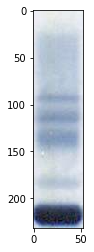

In [163]:
plt.imshow(X_collapsed_vert[200])
plt.show()

### Consistent sizing

In [164]:
input_shape = (233, 60, 4)
input_dim = (60, 233)
num_classes = 2

# Resize images
def resize_images(imgs):
    imgs_resized = []
    for img in imgs:
        img_resized = cv2.resize(img, input_dim)
        imgs_resized.append(img_resized)
    return np.array(imgs_resized)

X_resized = resize_images(X_collapsed_vert)
len(X_resized)

567

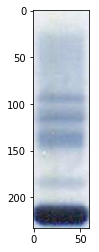

In [165]:
plt.imshow(X_resized[200])
plt.show()

### Densitometry (Horizontal Mean)

In [166]:
# Mean across horizontal axis
def calc_lane_means(lanes):
    lanes_means = []
    for lane in lanes:
        lane_mean = lane.mean(axis=1)
        # Just take the blue channels
        lanes_means.append(lane_mean[:, 2])

    return lanes_means

X_means = np.array(calc_lane_means(X_resized))
len(X_means), X_means[0].shape, len(y)

(567, (233,), 567)

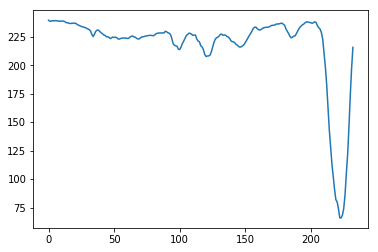

In [167]:
plt.plot(X_means[0])
plt.show()

### Plot Function

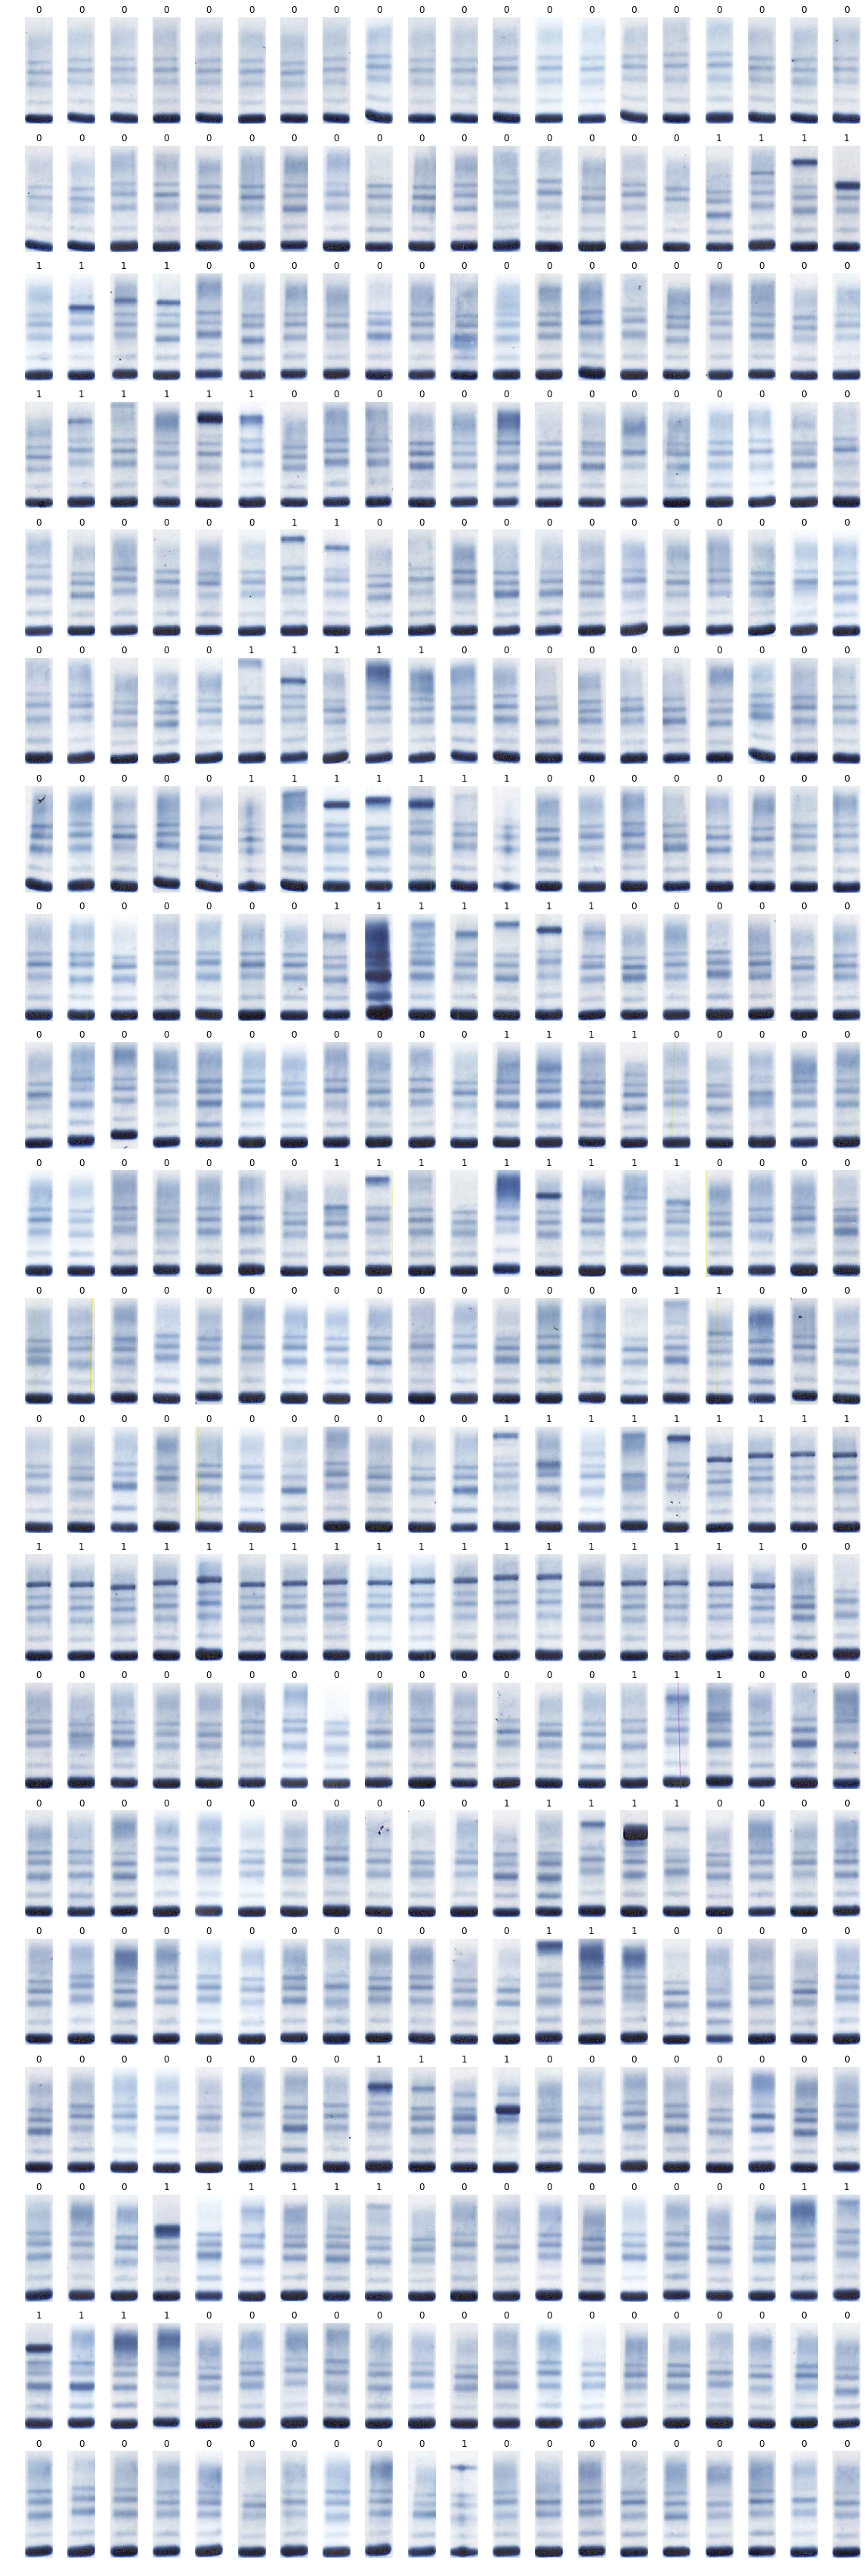

In [217]:
def plot_lanes(imgs, labels, width=20, height=None, cols=20):
    # Dynamic plot sizing
    count = len(imgs)
    ratio = 65.0 / 400.0
    if not height:
        height = int(count * ratio)
    
    plt.figure(figsize=(width, height))
    for i, img in enumerate(imgs):
        rows = int(count / cols) + 1
        plt.subplot(rows, cols, 1 + i)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
        
plot_lanes(X_resized[:400], y[:400])
plt.show()

### Plot Ctrls and Conditions

407 567
160 567


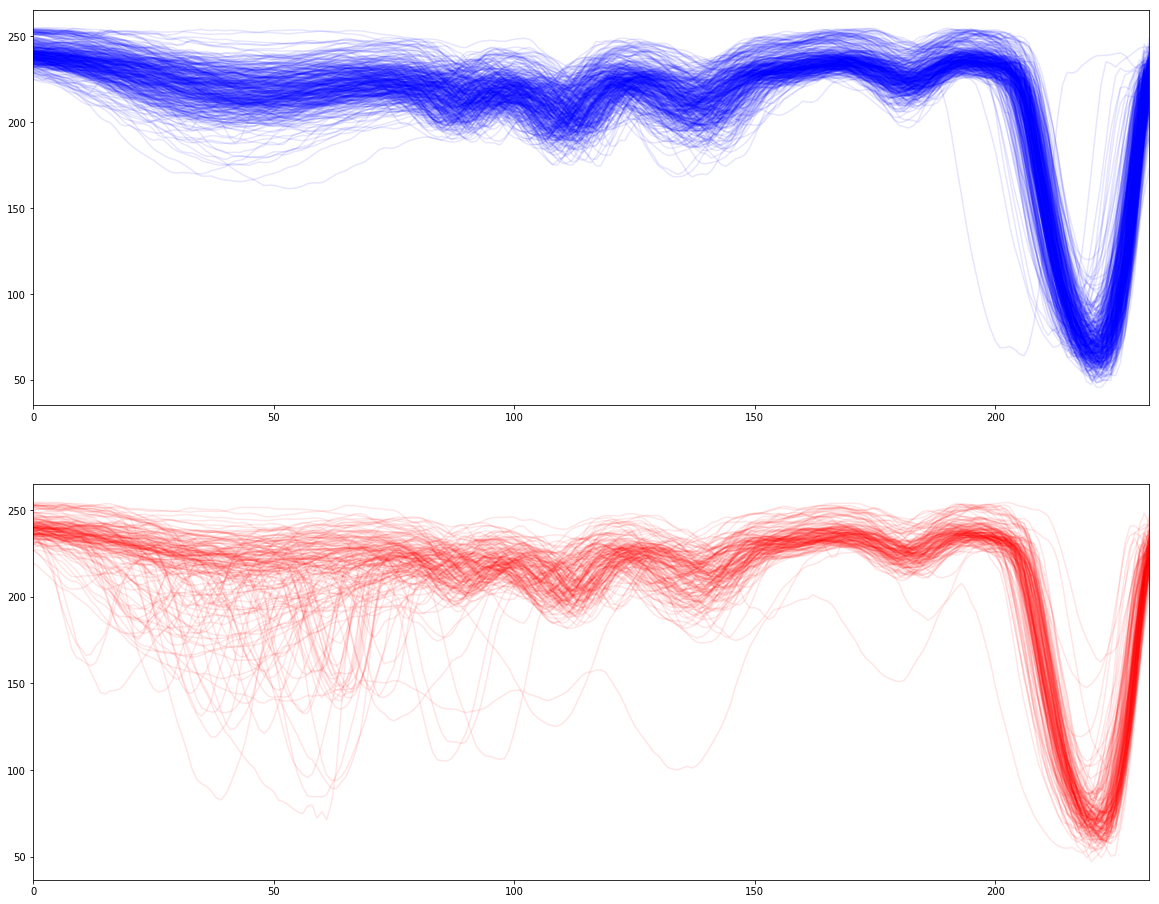

In [168]:
plt.figure(figsize=(20, 16))

X_means_df = pd.DataFrame(X_means)

ctrl = X_means_df[y == 0]
print len(ctrl), len(y)
plt.subplot(211)
ctrl.T.plot(alpha=.1, color='blue', ax=plt.gca(), legend=None, label='ctrl')

dz = X_means_df[y == 1]
print len(dz), len(y)
plt.subplot(212)
dz.T.plot(alpha=.1, color='red', ax=plt.gca(), legend=None, label='dz')

plt.show()

### Means

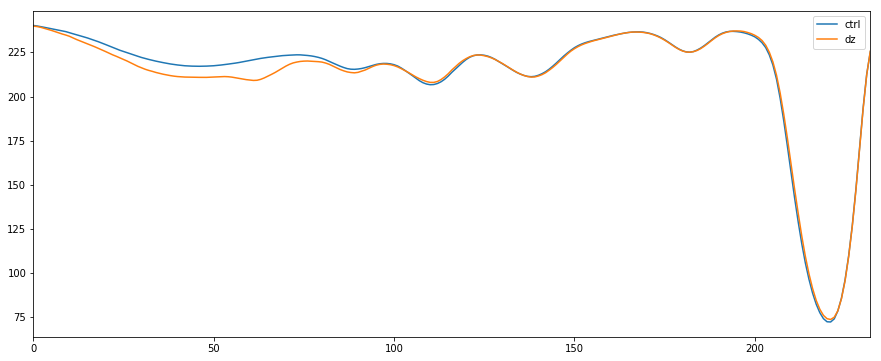

In [169]:
plt.figure(figsize=(15, 6))
np.mean(X_means_df[y == 0]).plot(label='ctrl')
np.mean(X_means_df[y == 1]).plot(label='dz')
plt.legend()
plt.show()

### Mean difference

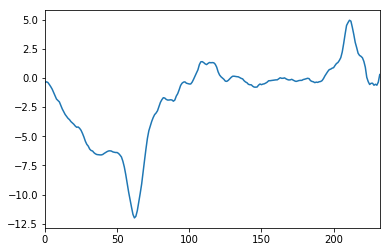

In [170]:
diff = np.mean(X_means_df[y == 1]) - np.mean(X_means_df[y == 0])
diff.plot()
plt.show()

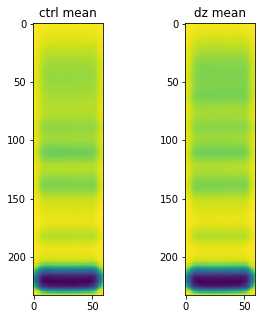

In [171]:
ctrl_mean = np.mean(X_resized[y==0], axis=0)[:, :, 2]
plt.figure(figsize=(5, 5))
plt.subplot(121)
plt.imshow(ctrl_mean, cmap="viridis")
plt.title('ctrl mean')

dz_mean = np.mean(X_resized[y==1], axis=0)[:, :, 2]
plt.subplot(122)
plt.imshow(dz_mean, cmap="viridis")
plt.title('dz mean')

plt.show()

### Smooth densitometry

/Users/ianjohnson/.virtualenvs/tensorflow2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


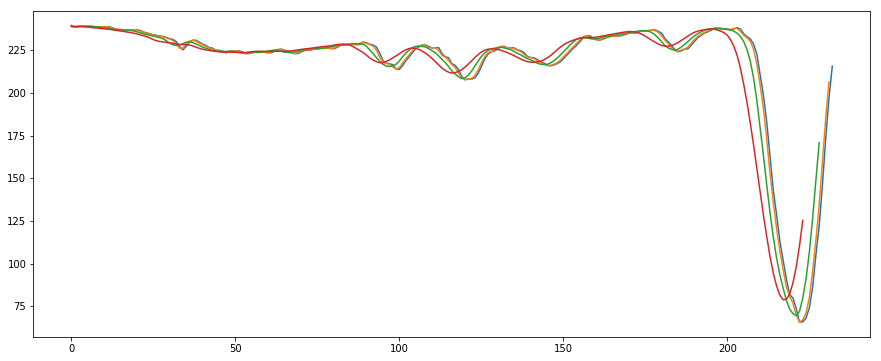

In [172]:
def smooth_lanes(X, N):
    plt.figure(figsize=(15, 6))
    plt.plot(X_means[0])
    
    smootheds = []
    for n in N:
        smoothed = [pd.rolling_mean(x, n)[n - 1:] for x in X]
        smootheds.append(smoothed)
        plt.plot(smoothed[0])
        plt.legend()
        
    plt.show()
    return smootheds

X_smoothed = smooth_lanes(X_means, [2, 5, 10])[0]

### Only top of lane

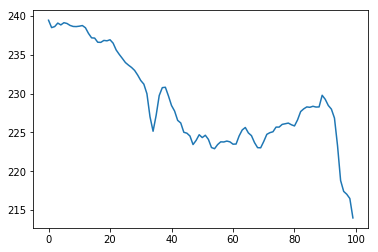

In [198]:
X_means_top = [x[0:100] for x in X_means]
plt.plot(X_means_top[0])
plt.show()

# Predictions

In [212]:
# Convert to DF in order to map back to original images
X_means_df = pd.DataFrame(X_means)

x_train, x_test, y_train, y_test = train_test_split(X_means_df, y_df[0], stratify=y_df[0])

# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

x_train[0].shape, x_test[0].shape, y_train.shape, y_test.shape

((425,), (142,), (425,), (142,))

### Sklearn

In [213]:
def grid_search_metrics(pipe, param_grid):
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc')
    grid.fit(x_train, y_train)
    print("Best GS score: {}".format(grid.best_score_))
    print("Best params: {}".format(grid.best_params_))
    score = grid.score(x_test, y_test)
    print("Best test score: {}".format(score))
    print("Overfitting amount: {}".format(grid.best_score_ - score))

In [214]:
pipe = Pipeline([
    ("variance", VarianceThreshold()),
    ("selection_1", SelectKBest(score_func=f_classif)),
    ("polys", PolynomialFeatures()),
    ("scaling", StandardScaler()),
    ("selection_2", SelectKBest(score_func=f_classif)),
    ("model", RandomForestClassifier(class_weight={0: 1, 1: 3}))
])

param_grid = {
    'selection_1__k': [45], #[45, 50, 55],
    'selection_2__k': [600], #[600, 700, 800],
    
    "model__max_depth": [None], #[3, None],
    "model__max_features": [13], #[13, 14, 15],
    "model__min_samples_split": [3], #[2, 3, 4],
    "model__min_samples_leaf": [10], #[7, 10, 15],
    "model__bootstrap": [False], #[True, False],
    "model__criterion": ['entropy'], #["gini", "entropy"]
}

grid_search_metrics(pipe, param_grid)

Best GS score: 0.798946435301
Best params: {'model__max_features': 13, 'selection_1__k': 45, 'model__criterion': 'entropy', 'model__max_depth': None, 'selection_2__k': 600, 'model__min_samples_leaf': 10, 'model__min_samples_split': 3, 'model__bootstrap': False}
Best test score: 0.761274509804
Overfitting amount: 0.037671925497


### Confusion Matrix

In [215]:
pipe.fit(x_train, y_train)
preds = pipe.predict(x_test)

missed = (np.abs(preds - y_test)).sum()
print "Missed: ", missed

print "False Positives:"
print ((preds - y_test) == 1).sum()

print "False Negatives:"
print ((preds - y_test) == -1).sum()

confusion_matrix(preds, y_test, labels=[0, 1])

Missed:  39
False Positives:
7
False Negatives:
32


array([[95, 32],
       [ 7,  8]])

### Plot misclassified examples

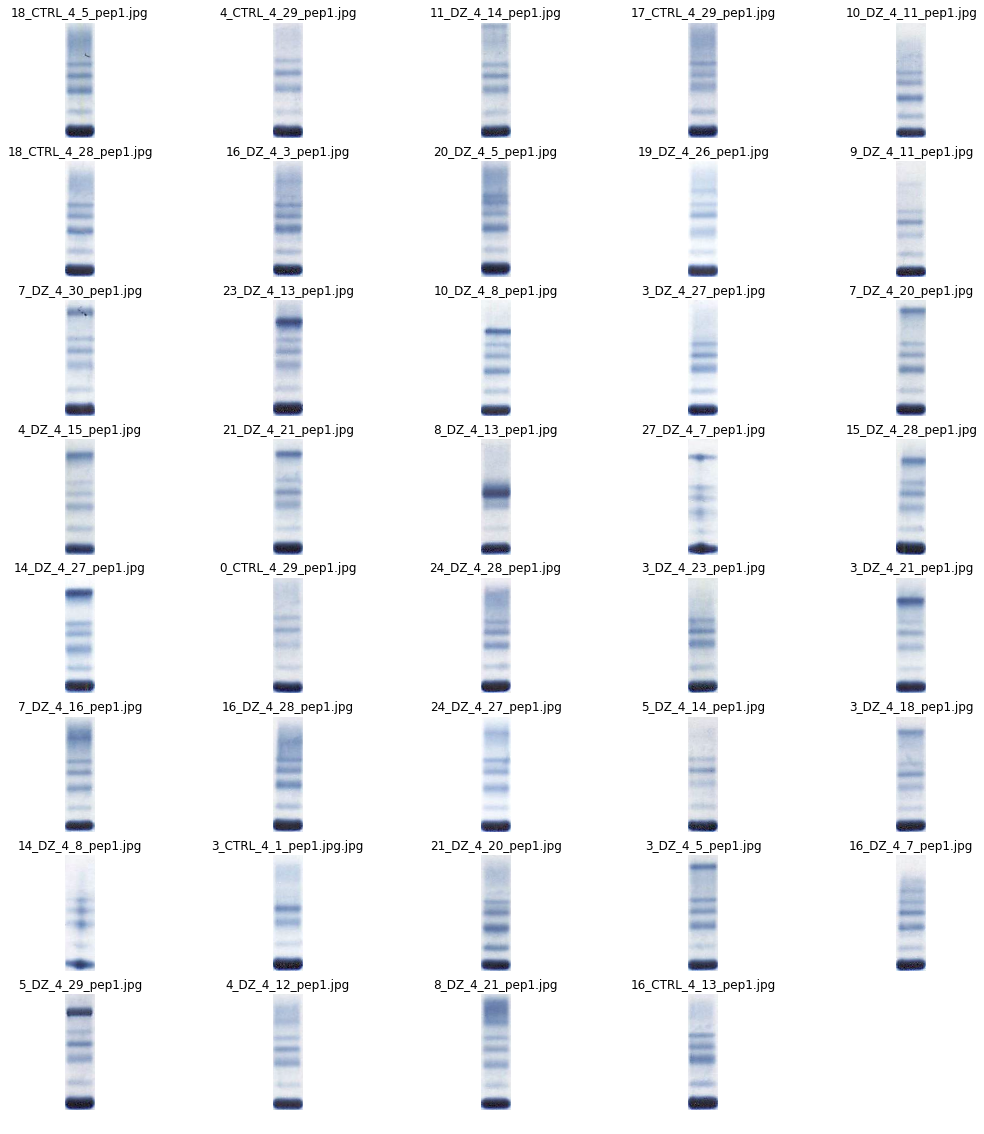

In [216]:
misclassified = np.where(y_test != preds)[0]
# print y_test.iloc[misclassified].tolist()

orig_indices = y_test.iloc[misclassified].index

misclassified_lanes = X_resized[orig_indices]
misclassified_filenames = np.array(train_image_files)[orig_indices]

plot_lanes(misclassified_lanes, misclassified_filenames, width=18, height=20, cols=5)
plt.show()

We are missing some obvious dz cases --> underpredicting on positives
    - some show bands, and seem like obvious mistakes
    - others are labeled as DZ, but don't appear very suspicious (to my untrained eye). Are they labeled as DZ for alternative reasons? Need to check the spreadsheet.

### CNN

In [94]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=50,
          epochs=3,
          verbose=1,
          validation_data=(x_test, y_test))